# Auto Encoder

## Import

In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import pandas as pd
from tqdm import tqdm, trange
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error
from scipy import sparse
import random
import time
import requests
from bs4 import BeautifulSoup
import bottleneck as bn

## Config

In [17]:
cfg = {
    "K": 1024,
    "lr" : 1e-4,
    "n_epochs" : 120,
    "data_dir" : "./dataset",
    "data_file" : "user_problem_mat.npz",
    "batch_size" : 64,
    "test_batch_size" : 32,
    "test_ratio" : 0.3,
    "topks" : [10,20,50],
    "const" : False,
    "model" : "auto_encoder"
}
cfg["model_path"] = f"./saved_model/{cfg['model']}_K_{cfg['K']}_{'const' if cfg['const'] else ''}.pt"
cfg["device"] = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f'Using {cfg["device"]} device')

Using cuda device


## Utils

In [3]:
import gc

def clear():
    torch.cuda.empty_cache()
    gc.collect()

#########################################
################# Test ##################
#########################################

def getLabel(test_data, pred_data):
    r = []
    for i in range(len(test_data)):
        groundTrue = test_data[i]
        predictTopK = pred_data[i]
        pred = list(map(lambda x: x in groundTrue, predictTopK))
        pred = np.array(pred).astype("float")
        r.append(pred)
    return np.array(r).astype('float')

def NDCGatK_r(test_data,r,k):
    """
    Normalized Discounted Cumulative Gain
    rel_i = 1 or 0, so 2^{rel_i} - 1 = 1 or 0
    """
    assert len(r) == len(test_data)
    pred_data = r[:, :k]

    test_matrix = np.zeros((len(pred_data), k))
    for i, items in enumerate(test_data):
        length = k if k <= len(items) else len(items)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = np.sum(max_r * 1./np.log2(np.arange(2, k + 2)), axis=1)
    dcg = pred_data*(1./np.log2(np.arange(2, k + 2)))
    dcg = np.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg/idcg
    ndcg[np.isnan(ndcg)] = 0.
    return np.sum(ndcg)

def RecallPrecision_ATk(test_data, r, k):
    """
    test_data should be a list? cause users may have different amount of pos items. shape (test_batch, k)
    pred_data : shape (test_batch, k) NOTE: pred_data should be pre-sorted
    k : top-k
    """
    right_pred = r[:, :k].sum(1)
    precis_n = k
    recall_n = np.array([len(test_data[i]) for i in range(len(test_data))])
    recall = np.sum(right_pred/recall_n)
    precis = np.sum(right_pred)/precis_n
    return {'recall': recall, 'precision': precis}

def test_one_batch(X, cfg):
    sorted_items = X[0].numpy()
    groundTrue = X[1]
    r = getLabel(groundTrue, sorted_items)
    pre, recall, ndcg = [], [], []
    for k in cfg['topks']:
        ret = RecallPrecision_ATk(groundTrue, r, k)
        pre.append(ret['precision'])
        recall.append(ret['recall'])
        ndcg.append(NDCGatK_r(groundTrue,r,k))
    return {'recall':np.array(recall), 
            'precision':np.array(pre), 
            'ndcg':np.array(ndcg)}

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36'}    
    
def add_to_user_problem_mat(idx, id, user_problem_mat : np.array):
    data = requests.get(f'https://www.acmicpc.net/user/{id}', headers=headers)
    soup = BeautifulSoup(data.text, 'html.parser')
    trs = soup.select('div.problem-list')

    for tr in trs:
        problem_nums = tr.select('a')
            
        for problem_num in problem_nums :

            problem_num = int(problem_num.text) - 1000
            #print(problem_num)
            try:
                user_problem_mat[idx,problem_num] = 1
            except:
                print("범위를 벗어난 문제 번호 : " + str(problem_num))

def print_result(res):
    print(f'precision : {res["precision"]}')
    print(f'recall : {res["recall"]}')
    print(f'ndcg : {res["ndcg"]}')
    print(f'test_loss : {res["test_loss"]}')       
    
def random_sample(num_col, num_row, min_ratio=0.01, max_ratio=0.02):
    test_s_mat_rand = np.zeros((num_col,num_row))

    for i in range(num_col):
        min_num = int(num_row * min_ratio)
        max_num = int(num_row * max_ratio)
        num_sample = random.sample(range(min_num,max_num),1)[0]

        num_list = random.sample(range(num_row),num_sample)
        
        test_s_mat_rand[i][num_list] = 1
    
    return test_s_mat_rand

def print_sparcity(mat):
    if type(mat) != np.array : mat = np.array(mat)
    
    len_zeros = len(np.where(mat == 0)[0])
    len_ones = len(np.where(mat != 0)[0])
    sparcity = len_zeros / (len_zeros + len_ones)
    print(f"0 개수 : {len_zeros}")
    print(f"1 개수 : {len_ones}")
    print(f"sparsity : {sparcity}")

## Model

In [4]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        
    def getUsersRating(self, user_row):
        raise NotImplementedError

class AutoEncoder(BaseModel):
    
    def __init__(self, item_n, cfg):
        """
        Arguments
        - item_n : count of items
        - cfg : configuration dict
            - K (int)       : number of latent dimensions
            - device : using device
        """
        super(AutoEncoder, self).__init__()
        # convert ndArray
        self.item_n = item_n
        self.K = cfg["K"]
        self.device = cfg["device"]
        
        # Initialize user and item latent feature matrice
        self.I_1 = nn.Linear(self.item_n, self.K, bias=True, device = self.device)
        self.I_2 = nn.Linear(self.K, self.item_n, bias=True, device = self.device)

        nn.init.normal_(self.I_1.weight, std=1./self.K)
        nn.init.normal_(self.I_2.weight, std=1./self.K)

    def forward(self, x):
        user_emb = self.I_1(x)
        rating = self.I_2(user_emb)
        #rating = torch.sigmoid(rating)
    
        return rating 

    def getUsersRating(self, user_row : np.array):
        return self.forward(torch.Tensor(user_row).to(self.device)).cpu().detach().numpy()

# VAE model
class VAE(nn.Module):
    def __init__(self, 
                 item_n,
                 cfg,
                 hidden_dims = [512,256]):
        super(VAE, self).__init__()
        
        self.item_n = item_n
        self.K = cfg["K"]
        self.device = cfg["device"]
        
        # Encoder
        self.le_1 = nn.Sequential(
            nn.Linear(item_n, hidden_dims[0]),
        )

        self.le_2 = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
        )
        
        self.mu = nn.Linear(hidden_dims[1], self.K)
        self.logvar = nn.Linear(hidden_dims[1], self.K)

        # Decoder
        self.ld_1 = nn.Sequential(
            nn.Linear(self.K, hidden_dims[1]),
        )

        self.ld_2 = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[0]),
        )

        # output layer
        self.out = nn.Linear(hidden_dims[0], item_n)

    def encode(self, x):
        h1 = F.relu(self.le_1(x))
        h2 = F.relu(self.le_2(h1))
        return self.mu(h2), self.logvar(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        h1 = F.relu(self.ld_1(z))
        h2 = F.relu(self.ld_2(h1))
        return torch.sigmoid(self.out(h2))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def getUsersRating(self, user_row : np.array):        
        rating , _, _ = self.forward(torch.Tensor(user_row).to(self.device))
        rating = rating.cpu().detach().numpy()        
        return rating

## DataSet

In [5]:
# Dataset 상속
class AEDataset(Dataset): 
    def __init__(self, sparse_matrix, device='cuda', test_ratio=0.3, edit_mat=True, log=True):
        assert type(sparse_matrix) == np.ndarray
        
        self.device = device
        self.sparse_matrix = sparse_matrix
        self.edit_mat = edit_mat

        self.maxK = max(cfg['topks'])
        self.test_dict = {}

        self.len_test_ones = 0
        self.len_train_ones = 0
        
        len_test_fail = 0
        nz_probs = self.sparse_matrix.sum(0).nonzero()[0]
        
        for user in range(len(self.sparse_matrix)):      
            items = self.sparse_matrix[user].nonzero()[0]
            len_items = len(items)
            len_sample = int(len_items * test_ratio)
            
            if len_sample >= self.maxK :
                sample_nums = random.sample(range(0,len_items),len_sample)                                                          
                sampled_items = items[sample_nums]
                                
                #sampled_items = list(set(sampled_items) - slp_idx)
                
                if edit_mat:
                    self.sparse_matrix[user][sampled_items] = 0.
                self.test_dict[user] = sampled_items  
                self.len_test_ones += len(sampled_items)
                self.len_train_ones += (len_items-len(sampled_items))
            else:
                len_test_fail += 1
        
        self.nz_probs = self.sparse_matrix.sum(0).nonzero()[0]
        if log:
            print(f"\n{len(nz_probs) - len(self.nz_probs)}")

            print("complete making test dict")
            print(f"length of failed test data : {len_test_fail}\n")
            print(f"train dict length : {self.len_train_ones}")
            print(f"test dict length : {self.len_test_ones}")
            print(f"set train_test_ratio : {test_ratio}")
            print(f"result train_test_ratio : {self.len_test_ones / (self.len_train_ones+self.len_test_ones)}")

    # 총 데이터의 개수를 리턴
    def __len__(self): 
        return len(self.sparse_matrix)

    # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
    def __getitem__(self, idx): 
        x = torch.FloatTensor(self.sparse_matrix[idx]).to(self.device)
        return x
    
    # 유저가 푼 문제번호 반환
    def get_user_pos_items(self, users):
        posItems = []
        for user in users:
            posItems.append(self.sparse_matrix[user].nonzero()[0])
        return posItems
    

In [6]:
data_path = f'{cfg["data_dir"]}/{cfg["data_file"]}'
train_s_mat = sparse.load_npz(data_path).astype(np.float32).toarray()
test_s_mat = sparse.load_npz(data_path).astype(np.float32).toarray()

train_dataset = AEDataset(train_s_mat, test_ratio=cfg['test_ratio'])
test_dataset = AEDataset(test_s_mat, test_ratio=cfg['test_ratio'])

train_dataloader = DataLoader(train_dataset, batch_size=cfg["batch_size"])
test_dataloader = DataLoader(test_dataset, batch_size=cfg["batch_size"])


1017
complete making test dict
length of failed test data : 26

train dict length : 493564
test dict length : 209924
set train_test_ratio : 0.3
result train_test_ratio : 0.2984045214701601

986
complete making test dict
length of failed test data : 26

train dict length : 493564
test dict length : 209924
set train_test_ratio : 0.3
result train_test_ratio : 0.2984045214701601


## Train & Test

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, X in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)      

        loss_const = 0.
        if cfg['const']:
            sel = dataloader.dataset.nz_probs
            mul_weight_diag = (model.I_1.weight.T[sel] * model.I_2.weight[sel]).sum(1)
            loss_const = 1e0 * torch.sum((mul_weight_diag - 0) ** 2)     
                
        loss = loss_fn(pred, X)
        
        loss_all = loss + loss_const
        
        # Backpropagation
        optimizer.zero_grad()
        loss_all.backward()
        optimizer.step()
    
    return loss, loss_const

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction = 'sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

def train(dataloader, model , optimizer):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        data = data.to(cfg['device'])
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)

        BCE, KLD = loss_function(recon_batch, data, mu, logvar)

        loss = BCE + KLD

        loss.backward()

        train_loss += loss.item()

        optimizer.step()

    return train_loss / len(dataloader.dataset), BCE.item(), KLD.item()

def minibatch(*tensors, **kwargs):

    batch_size = kwargs.get('batch_size', cfg['batch_size'])

    if len(tensors) == 1:
        tensor = tensors[0]
        for i in range(0, len(tensor), batch_size):
            yield tensor[i:i + batch_size]
    else:
        for i in range(0, len(tensors[0]), batch_size):
            yield tuple(x[i:i + batch_size] for x in tensors)

def _test_loop(dataloader, Recmodel, cfg, loss_fn=None, exclude=True, addPos=False):    
    u_batch_size = cfg['test_batch_size']
    dataset = dataloader.dataset
    testDict: dict = dataset.test_dict
    # eval mode with no dropout
    try:
        Recmodel = Recmodel.eval()
    except:
        print("model is not a torch model")
        
    max_K = max(cfg['topks'])
    results = {'precision': np.zeros(len(cfg['topks'])),
               'recall': np.zeros(len(cfg['topks'])),
               'ndcg': np.zeros(len(cfg['topks'])),
               'test_loss' : 0}
    
    with torch.no_grad():
        users = list(testDict.keys())
        try:
            assert u_batch_size <= len(users) / 10
        except AssertionError:
            print(f"test_u_batch_size is too big for this dataset, try a small one {len(users) // 10}")
        users_list = []
        rating_list = []
        groundTrue_list = []
        # auc_record = []
        # ratings = []
        total_batch = len(users) // u_batch_size + 1
        for batch_users in minibatch(users, batch_size=u_batch_size):
            groundTrue = [list(testDict[u]) for u in batch_users]
            _batch_users = dataloader.dataset[batch_users]
            
            rating = torch.Tensor(Recmodel.getUsersRating(_batch_users.cpu().detach().numpy()))
            _batch_users = torch.Tensor(_batch_users).cpu()
                
            if loss_fn is not None:
                results['test_loss'] += loss_fn(rating, _batch_users).item()
            
            #rating = rating.cpu()
            #print('Exclude Rated Item')
            allPos = dataset.get_user_pos_items(batch_users)
            
            if exclude:
                exclude_index = []
                exclude_items = []
                for range_i, items in enumerate(allPos):
                    exclude_index.extend([range_i] * len(items))
                    exclude_items.extend(items)
                rating[exclude_index, exclude_items] = -(1<<10)

            if addPos:
                for i in range(len(batch_users)):
                    groundTrue[i].extend(allPos[i])

            _, rating_K = torch.topk(rating, k=max_K)

            del rating    
            
            users_list.append(batch_users)
            rating_list.append(rating_K.cpu())
            groundTrue_list.append(groundTrue)

        assert total_batch == len(users_list)
        X = zip(rating_list, groundTrue_list)
        pre_results = []
        for x in X:
            pre_results.append(test_one_batch(x,cfg))
        scale = float(u_batch_size/len(users))
        for result in pre_results:
            results['recall'] += result['recall']
            results['precision'] += result['precision']
            results['ndcg'] += result['ndcg']
        results['recall'] /= float(len(users))
        results['precision'] /= float(len(users))
        results['ndcg'] /= float(len(users))
        results['test_loss'] /= total_batch
        return results

def save_result_to_tensor_board(result, epoch):
    for i, k in enumerate(cfg["topks"]):
        writer.add_scalar(f"Precision/@{k}", result['precision'][i], epoch)
        writer.add_scalar(f"Recall/@{k}", result['recall'][i], epoch)
        writer.add_scalar(f"ndcg/@{k}", result['ndcg'][i], epoch)
        
def _save_result_to_tensor_board(result, epoch, dev='Train'):
    for key, val in result.items():
        if key == "test_loss" : continue
        res_dict = {}
        for k, v in zip(cfg["topks"],val):
            res_dict[f"@{k}_{dev}"] = v
            
        writer.add_scalars(f"{key}", res_dict , epoch)
        
def __save_result_to_tensor_board(result, epoch, dev='Train'):        
    for i, k in enumerate(cfg["topks"]):
        writer.add_scalars(f"{dev}/@{k}", {
            "precision" : result['precision'][i],
            'recall' : result['recall'][i],
            'ndcg' : result['ndcg'][i]
        }, epoch)
        
def _save_result_avg(result, key, epoch, name='avg'): 
    res_dict = {name : result}
    writer.add_scalars(f"{key}", res_dict , epoch)

### AutoEncoder

In [18]:
RecModel = AutoEncoder(train_s_mat.shape[1], cfg)
optim = torch.optim.Adam(RecModel.parameters(), lr=cfg["lr"], betas=(0.9, 0.999), weight_decay=1e-6)
loss_fn = torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
#loss_fn = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean')

In [19]:
writer = SummaryWriter()
max_prec = 0

In [20]:
st_num = 0
test_Indicator = "precision"

max_prec = 0
for i in tqdm(range(st_num,cfg["n_epochs"]+st_num)):
    if i % 5 == 0:   
        test_res = _test_loop(train_dataloader, RecModel, cfg, loss_fn)
        t_res = _test_loop(test_dataloader, RecModel, cfg, loss_fn)
        
        if i % 20 == 0: 
            print("TEST")
            print_result(test_res)
            print("TEST - Another")
            print_result(t_res)
            print("==========================")
            
        _save_result_to_tensor_board(test_res, i)
        _save_result_to_tensor_board(t_res, i, dev='Test')
        writer.add_scalar(f"Loss/test", test_res['test_loss'], i)

        if max_prec < max(t_res[test_Indicator]) :
            max_prec = max(t_res[test_Indicator])
            torch.save(RecModel.state_dict(), cfg["model_path"])
            
        print(f"max_prec: {max_prec:>7f}")
    loss, loss_const = train_loop(train_dataloader, RecModel, loss_fn, optim)  
    writer.add_scalar(f"Loss/train", loss, i)
    if i % 10 == 0:
        print(f"loss: {loss:>7f}  [{i:>5d}/{cfg['n_epochs']+st_num:>5d}]")
        print(f"loss_const: {loss_const:>7f}  [{i:>5d}/{cfg['n_epochs']+st_num:>5d}]")


  0%|                                                                                          | 0/120 [00:00<?, ?it/s]

TEST
precision : [0.00359741 0.00363783 0.00363783]
recall : [0.00041063 0.00086987 0.00218821]
ndcg : [0.00354973 0.00358507 0.00361277]
test_loss : 0.007700000388117937
TEST - Another
precision : [0.00355699 0.00359741 0.00355699]
recall : [0.00041835 0.00085868 0.00209595]
ndcg : [0.00335469 0.00344125 0.00348641]
test_loss : 0.007699655494294488
max_prec: 0.003597



  1%|▋                                                                                 | 1/120 [00:05<10:25,  5.26s/it]

loss: 0.003519  [    0/  120]
loss_const: 0.000000  [    0/  120]


  4%|███▍                                                                              | 5/120 [00:08<02:11,  1.15s/it]

max_prec: 0.845513


  8%|██████▊                                                                          | 10/120 [00:15<01:53,  1.03s/it]

max_prec: 0.890703



  9%|███████▍                                                                         | 11/120 [00:18<03:19,  1.83s/it]

loss: 0.002391  [   10/  120]
loss_const: 0.000000  [   10/  120]


 12%|██████████▏                                                                      | 15/120 [00:21<01:46,  1.01s/it]

max_prec: 0.915441


 17%|█████████████▌                                                                   | 20/120 [00:28<01:40,  1.00s/it]

TEST
precision : [0.9128941  0.86899757 0.719135  ]
recall : [0.11896322 0.22533612 0.4560467 ]
ndcg : [0.92235686 0.88853155 0.76892039]
test_loss : 0.003880705060556722
TEST - Another
precision : [0.93023444 0.88506467 0.74022635]
recall : [0.1210644  0.22879717 0.46687415]
ndcg : [0.93907045 0.9045202  0.78880413]
test_loss : 0.0040861546384313935
max_prec: 0.930234



 18%|██████████████▏                                                                  | 21/120 [00:31<02:57,  1.79s/it]

loss: 0.000589  [   20/  120]
loss_const: 0.000000  [   20/  120]


 21%|████████████████▉                                                                | 25/120 [00:34<01:35,  1.00s/it]

max_prec: 0.942805


 25%|████████████████████▎                                                            | 30/120 [00:41<01:29,  1.01it/s]

max_prec: 0.947454



 26%|████████████████████▉                                                            | 31/120 [00:44<02:35,  1.74s/it]

loss: 0.000208  [   30/  120]
loss_const: 0.000000  [   30/  120]


 29%|███████████████████████▋                                                         | 35/120 [00:47<01:24,  1.01it/s]

max_prec: 0.954729


 33%|███████████████████████████                                                      | 40/120 [00:54<01:18,  1.01it/s]

TEST
precision : [0.89676637 0.85311237 0.71284559]
recall : [0.11781695 0.22345731 0.45936958]
ndcg : [0.90778076 0.87352648 0.76068255]
test_loss : 0.002645327667825115
TEST - Another
precision : [0.95820534 0.92356508 0.79438965]
recall : [0.12495177 0.23962402 0.50305873]
ndcg : [0.96562102 0.93893533 0.83680501]
test_loss : 0.0033080820770313344
max_prec: 0.958205



 34%|███████████████████████████▋                                                     | 41/120 [00:57<02:17,  1.74s/it]

loss: 0.000136  [   40/  120]
loss_const: 0.000000  [   40/  120]


 38%|██████████████████████████████▍                                                  | 45/120 [01:00<01:13,  1.01it/s]

max_prec: 0.959499


 42%|█████████████████████████████████▊                                               | 50/120 [01:07<01:08,  1.01it/s]

max_prec: 0.959499



 42%|██████████████████████████████████▍                                              | 51/120 [01:10<01:55,  1.67s/it]

loss: 0.000135  [   50/  120]
loss_const: 0.000000  [   50/  120]


 46%|█████████████████████████████████████▏                                           | 55/120 [01:13<01:03,  1.02it/s]

max_prec: 0.959499


 50%|████████████████████████████████████████▌                                        | 60/120 [01:20<00:59,  1.02it/s]

TEST
precision : [0.82283751 0.76491512 0.62226354]
recall : [0.10884806 0.20223548 0.40693341]
ndcg : [0.84044625 0.79386283 0.67500846]
test_loss : 0.0017553238117565902
TEST - Another
precision : [0.95715441 0.92303961 0.79590946]
recall : [0.12484501 0.23931607 0.50421174]
ndcg : [0.96507396 0.93853595 0.83793095]
test_loss : 0.0026746864657466994
max_prec: 0.959499



 51%|█████████████████████████████████████████▏                                       | 61/120 [01:23<01:39,  1.69s/it]

loss: 0.000150  [   60/  120]
loss_const: 0.000000  [   60/  120]


 54%|███████████████████████████████████████████▉                                     | 65/120 [01:26<00:53,  1.02it/s]

max_prec: 0.959499


 58%|███████████████████████████████████████████████▎                                 | 70/120 [01:32<00:48,  1.03it/s]

max_prec: 0.959499



 59%|███████████████████████████████████████████████▉                                 | 71/120 [01:36<01:23,  1.70s/it]

loss: 0.000101  [   70/  120]
loss_const: 0.000000  [   70/  120]


 62%|██████████████████████████████████████████████████▋                              | 75/120 [01:39<00:44,  1.01it/s]

max_prec: 0.959499


 67%|██████████████████████████████████████████████████████                           | 80/120 [01:45<00:39,  1.00it/s]

TEST
precision : [0.74890865 0.68215441 0.54176233]
recall : [0.09957156 0.18080582 0.35512659]
ndcg : [0.7715548  0.71683535 0.59688605]
test_loss : 0.0012397979780171926
TEST - Another
precision : [0.94911075 0.90864996 0.7738561 ]
recall : [0.12356328 0.23506264 0.48838243]
ndcg : [0.9582281  0.92684959 0.81919874]
test_loss : 0.002199186261397046
max_prec: 0.959499



 68%|██████████████████████████████████████████████████████▋                          | 81/120 [01:49<01:07,  1.72s/it]

loss: 0.000159  [   80/  120]
loss_const: 0.000000  [   80/  120]


 71%|█████████████████████████████████████████████████████████▍                       | 85/120 [01:52<00:35,  1.00s/it]

max_prec: 0.959499


 75%|████████████████████████████████████████████████████████████▊                    | 90/120 [01:58<00:30,  1.02s/it]

max_prec: 0.959499



 76%|█████████████████████████████████████████████████████████████▍                   | 91/120 [02:02<00:51,  1.76s/it]

loss: 0.000121  [   90/  120]
loss_const: 0.000000  [   90/  120]


 79%|████████████████████████████████████████████████████████████████▏                | 95/120 [02:05<00:25,  1.01s/it]

max_prec: 0.959499


 83%|██████████████████████████████████████████████████████████████████▋             | 100/120 [02:12<00:20,  1.03s/it]

TEST
precision : [0.60347615 0.52562652 0.3911156 ]
recall : [0.08070182 0.14067619 0.25999322]
ndcg : [0.6338507  0.56839889 0.44872087]
test_loss : 0.0009855978543129868
TEST - Another
precision : [0.91390461 0.856346   0.69759903]
recall : [0.11845525 0.2202012  0.43723364]
ndcg : [0.92867283 0.88337848 0.75357784]
test_loss : 0.0019021248355364571
max_prec: 0.959499



 84%|███████████████████████████████████████████████████████████████████▎            | 101/120 [02:15<00:33,  1.77s/it]

loss: 0.000120  [  100/  120]
loss_const: 0.000000  [  100/  120]


 88%|██████████████████████████████████████████████████████████████████████          | 105/120 [02:18<00:15,  1.01s/it]

max_prec: 0.959499


 92%|█████████████████████████████████████████████████████████████████████████▎      | 110/120 [02:25<00:09,  1.01it/s]

max_prec: 0.959499



 92%|██████████████████████████████████████████████████████████████████████████      | 111/120 [02:29<00:16,  1.80s/it]

loss: 0.000140  [  110/  120]
loss_const: 0.000000  [  110/  120]


 96%|████████████████████████████████████████████████████████████████████████████▋   | 115/120 [02:32<00:05,  1.01s/it]

max_prec: 0.959499


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [02:38<00:00,  1.32s/it]


In [21]:
writer.flush()
writer.close()

In [ ]:
# const => 0.964673
# no const => 0.959499

In [53]:
# 대각 값 확인
mul_emb = (RecModel.I_1.weight.T @ RecModel.I_2.weight.T).cpu().detach().numpy()
am = np.argmax(mul_emb,0)

cnt = 0
for i in range(len(am)):
    if am[i] == i : cnt+=1
print(cnt)
print(cnt / len(am))

clear()

0
0.0


In [18]:
max_prec

0.9351657235246567

In [36]:
print_result(_test_loop(test_dataloader, ae_const, cfg, loss_fn))

79it [00:01, 58.56it/s]


precision : [0.95206082 0.90860344 0.762497  ]
recall : [0.12497667 0.23716896 0.48620402]
ndcg : [0.95965917 0.92676056 0.81101567]
test_loss : 0.0040974134897601


### VAE

In [120]:
VAE_Model = VAE(train_s_mat.shape[1], cfg, hidden_dims = [1024,512]).to(cfg['device'])
optimizer = torch.optim.Adam(VAE_Model.parameters(), lr = 1e-4)

In [ ]:
writer = SummaryWriter()
st_num = 0
max_prec = 0
test_Indicator = "precision"

for i in tqdm(range(st_num,cfg["n_epochs"]+st_num)):
    if i % 5 == 0:   
        test_res = _test_loop(train_dataloader, VAE_Model, cfg, loss_fn)
        t_res = _test_loop(test_dataloader, VAE_Model, cfg, loss_fn)
        
        prec_avg = (max(test_res[test_Indicator])+max(t_res[test_Indicator]))/2
        if i % 20 == 0: 
            print("TEST")
            print_result(test_res)
            print("TEST - Another")
            print_result(t_res)
            print(f"{test_Indicator} - avg")
            print(prec_avg)
            print("==========================")
            
        _save_result_to_tensor_board(test_res, i)
        _save_result_to_tensor_board(t_res, i, dev='Test')
        _save_result_avg(prec_avg, test_Indicator, i)
        writer.add_scalar(f"Loss/test", test_res['test_loss'], i)

        if max_prec < prec_avg :
            max_prec = prec_avg
            torch.save(VAE_Model.state_dict(), cfg["model_path"])
            
    loss, BCE, KLD = train(train_dataloader, VAE_Model, optimizer)  
    
    writer.add_scalar("Train/Reconstruction Error", BCE, i)
    writer.add_scalar("Train/KL-Divergence", KLD, i)
    writer.add_scalar("Train/Total Loss" , loss, i)
    
    if i % 10 == 0:
        print(f"loss: {loss:>7f}  [{i:>5d}/{cfg['n_epochs']+st_num:>5d}]")

writer.flush()
writer.close()


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

TEST
precision : [0.0047696  0.00432498 0.00389652]
recall : [0.00057874 0.00101854 0.00237192]
ndcg : [0.00465985 0.0043775  0.00402546]
test_loss : 0.2504696330198875
TEST - Another
precision : [0.00355699 0.00367825 0.00366209]
recall : [0.00041859 0.00088726 0.00216251]
ndcg : [0.00348191 0.00359161 0.00361515]
test_loss : 0.2504686208871695
precision - avg
0.00422392886014551



  1%|▊                                                                                 | 1/100 [00:05<08:43,  5.28s/it]

loss: 10748.642892  [    0/  100]


 11%|████████▉                                                                        | 11/100 [00:19<02:50,  1.92s/it]

loss: 616.478139  [   10/  100]


 20%|████████████████▏                                                                | 20/100 [00:29<01:23,  1.05s/it]

TEST
precision : [0.73084074 0.65584074 0.5012692 ]
recall : [0.09388341 0.16698781 0.31311569]
ndcg : [0.74933706 0.69040027 0.55958529]
test_loss : 0.005476700783802722
TEST - Another
precision : [0.72821342 0.65701293 0.50118027]
recall : [0.0936547  0.16742044 0.31322853]
ndcg : [0.74817449 0.69160817 0.55986903]
test_loss : 0.005479186862850418
precision - avg
0.7295270816491513



 21%|█████████████████                                                                | 21/100 [00:33<02:27,  1.86s/it]

loss: 553.799468  [   20/  100]


 31%|█████████████████████████                                                        | 31/100 [00:46<02:02,  1.78s/it]

loss: 541.809768  [   30/  100]


 39%|███████████████████████████████▌                                                 | 39/100 [00:55<01:11,  1.16s/it]

# Tensorboard 시각화

In [22]:
%load_ext tensorboard

In [8]:
%reload_ext tensorboard

In [27]:
%tensorboard --logdir i

Reusing TensorBoard on port 6006 (pid 18328), started 0:02:12 ago. (Use '!kill 18328' to kill it.)

# TEST

### Dataset Setting

In [12]:
def get_test_dataloader(test_ratio=0.3, edit_mat=True, test_data_path = None, rand_like=False, log=True):
    if test_data_path is not None:
        # 미리 얻은 test_dataset으로 test
        test_s_mat = sparse.load_npz(test_data_path).astype(np.float32).toarray()
        if rand_like:
            test_s_mat = random_sample(test_s_mat.shape[0], test_s_mat.shape[1])
    else:
        test_s_mat = np.random.randint(2,size=train_s_mat.shape)
    if log:
        print_sparcity(test_s_mat)
    test_dataset = AEDataset(test_s_mat, test_ratio=test_ratio, edit_mat=edit_mat, log=log)
    test_dataloader = DataLoader(test_dataset, batch_size=cfg["batch_size"])
    
    return test_dataloader

In [15]:
# 미리 얻은 test_dataset으로 test
test_data_path = f'{cfg["data_dir"]}/{cfg["data_file"]}'
test_dataloader = get_test_dataloader(test_ratio=0.7, edit_mat=True, test_data_path = test_data_path, rand_like=False)

0 개수 : 66747396
1 개수 : 707604
sparsity : 0.9895099844340671

1935
complete making test dict
length of failed test data : 1

train dict length : 354429
test dict length : 353175
set train_test_ratio : 0.5
result train_test_ratio : 0.4991139111706548


In [144]:
# 실제와 비슷한 sparcity로 생성
test_all_rand_dataloader = get_test_dataloader(test_ratio=0.3, edit_mat=True, test_data_path = test_data_path, rand_like=True)

0 개수 : 66449668
1 개수 : 1005332
sparsity : 0.9850962567637684
complete making test dict
length of failed test data : 0

train dict length : 704853
test dict length : 300479
set train_test_ratio : 0.3
result train_test_ratio : 0.29888534334926176


In [145]:
# 완전 랜덤으로 생성 
test_rand_dataloader = get_test_dataloader(test_ratio=0.3, edit_mat=True, rand_like=False)

0 개수 : 33726607
1 개수 : 33728393
sparsity : 0.49998676154473354
complete making test dict
length of failed test data : 0

train dict length : 23611013
test dict length : 10117380
set train_test_ratio : 0.3
result train_test_ratio : 0.29996626284566835


### Model Comparing

In [33]:
# 모델 불러오기
ease = EASE(300)
ease.B = sparse.load_npz('./saved_model/ease_model.npz').toarray()

In [33]:
num_problem = test_s_mat.shape[1]
#cfg['K'] = 1024
#ae = AutoEncoder(num_problem, cfg)
ae_const = AutoEncoder(num_problem, cfg)
#ae.load_state_dict(torch.load(f"./saved_model/auto_encoder_K_1024_const.pt"))
ae_const.load_state_dict(torch.load(f"./saved_model/auto_encoder_K_1024_const_g.pt"))
#ae_const.load_state_dict(torch.load(cfg["model_path"]))

<All keys matched successfully>

## 실제 데이터 - 랜덤 데이터 비교

In [78]:
print("Test - AE_CONSTRAINT\n")
print("\n[ REAL DATA ]")
res = _test_loop(train_dataloader, ae_const, cfg)
print_result(res)
print("\n[ ALL_RANDOM DATA ]")
res = _test_loop(test_all_rand_dataloader, ae_const, cfg)
print_result(res)

print("\n[ RANDOM DATA ]")
res = _test_loop(test_rand_dataloader, ae_const, cfg)
print_result(res)

Test - AE_CONSTRAINT


[ REAL DATA ]
precision : [0.91572629 0.87022809 0.72493798]
recall : [0.12021676 0.22752979 0.46397714]
ndcg : [0.92628467 0.89091788 0.77453269]
test_loss : 0.0

[ ALL_RANDOM DATA ]


NameError: name 'test_all_rand_dataloader' is not defined

## 테스트 비교

In [ ]:
# 테스트 케이스 여러개 실험
mean_prec = 0
for i in tqdm(range(100)):
    test_dataloader = get_test_dataloader(test_ratio=0.3, edit_mat=True, test_data_path = test_data_path, rand_like=False, log=False)
    res = _test_loop(test_dataloader, ae_const, cfg)
    mean_prec += res['precision'][0]

    print(res['precision'][0])
    
print(mean_prec/100)

In [49]:
# 미리 얻은 test_dataset으로 test
test_data_path = f'{cfg["data_dir"]}/{cfg["data_file"]}'
test_dataloader = get_test_dataloader(test_ratio=0.3, edit_mat=True, test_data_path = test_data_path, rand_like=False)

0 개수 : 66747396
1 개수 : 707604
sparsity : 0.9895099844340671

1004
complete making test dict
length of failed test data : 26

train dict length : 493564
test dict length : 209924
set train_test_ratio : 0.3
result train_test_ratio : 0.2984045214701601


In [34]:
print("Test - AE_Const")
print("[ REAL DATA ]")
res = _test_loop(test_dataloader, ae_const, cfg)
print_result(res)

Test - AE_Const
[ REAL DATA ]
precision : [0.96467259 0.92920372 0.79510105]
recall : [0.12592511 0.24125968 0.50412026]
ndcg : [0.97123425 0.94425348 0.83860836]
test_loss : 0.0


In [31]:
print("Test - AE")
print("[ REAL DATA ]")
res = _test_loop(test_dataloader, ae, cfg)
print_result(res)

Test - AE
[ REAL DATA ]


NameError: name 'ae' is not defined

In [29]:
print("Test - EASE")
print("[ REAL DATA ]")
res = _test_loop(test_dataloader, ease, cfg, loss_fn)
print_result(res)

# print("\n[ ALL_RANDOM DATA ]")
# res = _test_loop(test_all_rand_dataloadder, ease, cfg, loss_fn)
# print_result(res)

# print("\n[ RANDOM DATA ]")
# res = _test_loop(test_rand_dataloader, ease, cfg, loss_fn)
# print_result(res)

Test - EASE
[ REAL DATA ]
model is not a torch model
precision : [0.96139854 0.92590946 0.79523848]
recall : [0.12548272 0.24037884 0.50482716]
ndcg : [0.96910368 0.94180521 0.83839845]
test_loss : 0.004028800863008468


## 임베딩 시각화

In [40]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import seaborn as sns
from matplotlib import pyplot as plt

In [12]:
# 태그로 라벨링
selected_tags = ['그리디 알고리즘', '다이나믹 프로그래밍', '브루트포스 알고리즘', '이분 탐색',
                '너비 우선 탐색', '깊이 우선 탐색', '데이크스트라', '플로이드–워셜', '비트마스킹', '분리 집합']
selected_tags_to_code = ['greedy','dynamic','broute','binary', 'bfs','dfs','dijks', 'floyd','bit','union']

tag_problem_mat = pd.read_csv(f"{cfg['data_dir']}/tag_problem_mat_all.csv", index_col = 0)
tag_problem_mat_trans = tag_problem_mat.T
tag_problem_mat_trans = tag_problem_mat_trans[selected_tags] # shape = (?, 10)
tag_problem_mat = tag_problem_mat_trans.T
tag_problem_mat_np = np.array(tag_problem_mat)

labels = np.array(['others'] * num_problem)

for i, tag in enumerate(selected_tags):
    num_list = tag_problem_mat_np[i].nonzero()[0]  
    labels[num_list] = selected_tags_to_code[i]

selected = np.where(labels!='others')
labels = labels[selected]

In [43]:
# 푼 문제, 안푼 문제로 라벨링
train_user_problem_mat = pd.read_csv(f"{cfg['data_dir']}/train_user_problem_mat.csv", index_col = 0)
user_problem_mat = np.array(train_user_problem_mat)

In [44]:
labels = np.array(['no'] * num_problem)
yes = user_problem_mat.sum(0).nonzero()[0]
no = np.where(user_problem_mat.sum(0)==0)[0]
labels[yes] = 'yes'

In [45]:
num_yes = len(yes)

In [46]:
# 축소한 차원의 수를 정합니다.
n_components = 2
# TSNE 모델의 인스턴스를 만듭니다.
model = TSNE(n_components=n_components, perplexity=30)

In [106]:
mul_emb = ae.I_1.weight.T @ ae.I_2.weight.T

In [107]:
mul_emb = mul_emb.cpu().detach().numpy()

In [78]:
ae_mul_embedded = model.fit_transform(mul_emb)

C:\Users\suhan\AppData\Local\Temp\ipykernel_15744\656586385.py:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=ae_mul_embedded[:,0], y=ae_mul_embedded[:,1], hue=labels, legend='full', palette=palette)


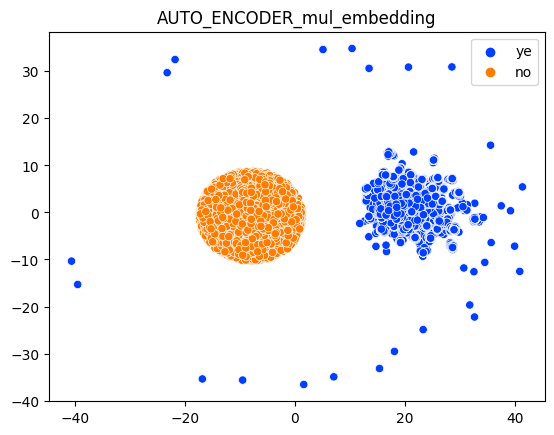

In [79]:
plt.title("AUTO_ENCODER_mul_embedding")
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=ae_mul_embedded[:,0], y=ae_mul_embedded[:,1], hue=labels, legend='full', palette=palette)
plt.show()

C:\Users\suhan\AppData\Local\Temp\ipykernel_1252\1530613956.py:9: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=ae_mul_embedded[:,0], y=ae_mul_embedded[:,1], hue=labels, legend='full', palette=palette)


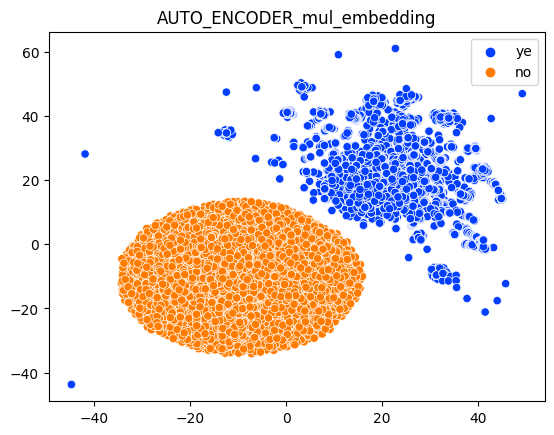

In [49]:
mul_emb = ae_const.I_1.weight.T @ ae_const.I_2.weight.T

mul_emb = mul_emb.cpu().detach().numpy()

ae_mul_embedded = model.fit_transform(mul_emb)

plt.title("AUTO_ENCODER_CONSTRAINT_mul_embedding")
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=ae_mul_embedded[:,0], y=ae_mul_embedded[:,1], hue=labels, legend='full', palette=palette)
plt.show()

In [36]:
ease_embedded = model.fit_transform(ease.B.transpose())

C:\Users\suhan\AppData\Local\Temp\ipykernel_13884\154922973.py:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=ease_embedded[:,0], y=ease_embedded[:,1], hue=labels, legend='full', palette=palette)


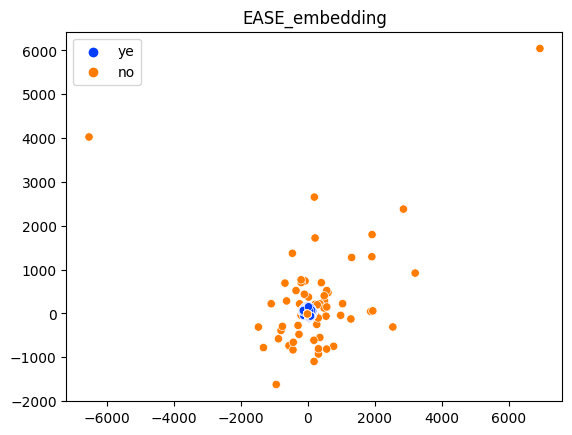

In [37]:
plt.title("EASE_embedding")
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=ease_embedded[:,0], y=ease_embedded[:,1], hue=labels, legend='full', palette=palette)
plt.show()

In [38]:
ease_embedded_clip = np.clip(ease_embedded,-200,200)

C:\Users\suhan\AppData\Local\Temp\ipykernel_13884\700786308.py:3: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x=ease_embedded_clip[:,0], y=ease_embedded_clip[:,1], hue=labels, legend='full', palette=palette)


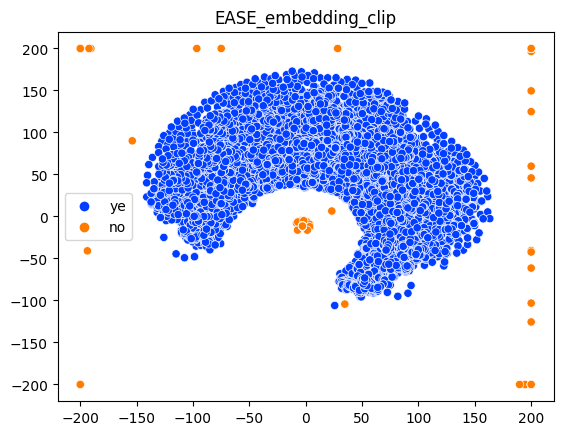

In [39]:
plt.title("EASE_embedding_clip")
palette = sns.color_palette("bright", 10)
sns.scatterplot(x=ease_embedded_clip[:,0], y=ease_embedded_clip[:,1], hue=labels, legend='full', palette=palette)
plt.show()

## 문제 유사도 시각화

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [52]:
%matplotlib inline

In [83]:
x = list(range(num_problem))

In [103]:
y = ease.B.T[0].flatten()

In [104]:
np.argsort(y)[::-1]

array([ 1557,     1,  1438, ..., 14596,  3386,  1638], dtype=int64)

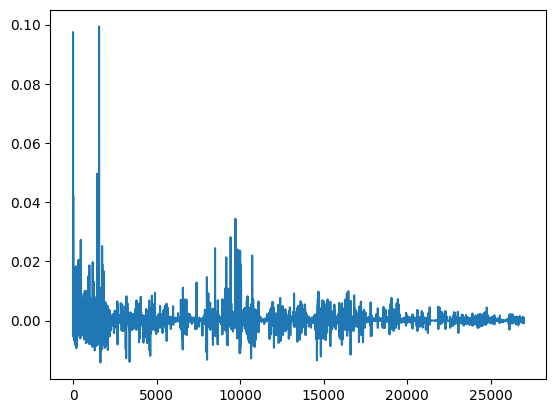

In [105]:
plt.plot(x,y)
plt.show()

# 유저에 따른 문제 추천

In [112]:
# 모델 불러오기
RecModel = AutoEncoder(train_s_mat, cfg)
RecModel.load_state_dict(torch.load(cfg["model_path"]))
RecModel.eval()

MFGDTorch(
  (I_1): Linear(in_features=26982, out_features=128, bias=True)
  (I_2): Linear(in_features=128, out_features=26982, bias=True)
)

In [116]:
st_pb_num = 1000
ed_pb_num = 27981
num_problem = ed_pb_num - st_pb_num + 1  # 1000 ~ 27981

NUM_TOP_PROBLEMS = 10
user_id = 'faang12594'

In [117]:
user_problem = np.zeros([1, num_problem])
add_to_user_problem_mat(0, user_id, user_problem)

result = RecModel.getUsersRating(user_problem)

범위를 벗어난 문제 번호 : 26982
범위를 벗어난 문제 번호 : 26983


In [118]:
# 유저가 푼 문제와 비슷한 유형 추천 - 예전
result[user_problem.nonzero()] = -np.inf
top_problems_by_user = bn.argpartition(-result, NUM_TOP_PROBLEMS, axis=1)[:, :NUM_TOP_PROBLEMS] # 값이 큰 10개 문제 고름
top_problems_by_user += 1000
print(top_problems_by_user)

[[16234 11657  1707  1976 17609 21758  1655  4149  5615  2436]]
